# Lab 9. Convolutional Networks

In this Lab we will focus on three different questions related to CNNs.

1) Understand the convolutions and pooling operators work

2) Learn how to use an CNN that has been already trained to solve ML tasks

3) Learn how to design and train an CNN to solve a ML task 

We will use material from the books:

- "Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. http://shop.oreilly.com/product/0636920052289.do 

- "Deep Learning with Python" by F. Chollet. https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438

which are recommended as Bibliography of the course.

We will also use the re-implementation of F. Chollet keras code as proposed in https://github.com/anastasios-stamoulis/deep-learning-with-csharp-and-cntk/tree/master/Python

In [22]:
# We start by importing the python libraries that we will use

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler


# Tensorflow library used for implementation of the DNNs
import tensorflow as tf


# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG


import keras
from __future__ import print_function
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.models import model_from_yaml
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist, boston_housing
from keras import regularizers 
import keras.backend as K


# Metrics and datasets in sklearn
from sklearn import metrics
import sklearn.datasets as data_load
from sklearn import preprocessing

The following functions serve to display RBB images

In [23]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [24]:
# This function set the seeds of the tensorflow function
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Convolutions and the Convolutional Layer

We start by discussing the building blocks of convolutional networks as implemented in tensorflow. 

The  function tf.nn.conv2d() computes a 2-D convolution given 4-D tensor, it receives as parameters:

- The input data of the layer (the output of the previous layer)
- A set of filters 
- The strides information for the application of those filters
- The padding scheme used with those filters


We will explain all these components and use two images to illustrate how they work. First, you will need to download the files and decompress it. The password is mlnn.

https://www.ehu.eus/zaindegi/index.php?action=download&item=cnn_images.zip&order=name&srt=yes


The first image is one of the Chillida scultures

In [25]:
# The image is loaded
image_C = mpimg.imread('cnn_images/Chillida.png')

# We get the size and number of channels of the image
height, width, channels = image_C.shape
print("Characteristcs of the image (height, width, channels):", height, width, channels)



Characteristcs of the image (height, width, channels): 180 270 3


The image is transformed to grayscale (only one channel)

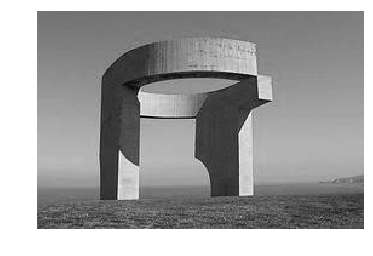

In [26]:
image_grayscale = image_C.mean(axis=2).astype(np.float32)
plot_image(image_grayscale)
plt.show()


# We reshape the image to a matrix on only two dimensions
images = image_grayscale.reshape(1, height, width, 1)

Now we will manually create two filters. Remember that in a convolutional network, the user specifies the size of the filters (also called kernels) but the contents of the filters are learned as part of the NN learning process. Tensorflow defines a set of filters as a tensor of four dimensions:

1. Height 
2. Width 
3. Input Channels
4. Output Channels

where usually the Height and Width of the filter are equal. We can define different filters for each input channel.  The number of Output Channels is the number of feature maps that will be the result of the kernel application. See the example below.


In [12]:
# We define 2 kernels of size 7x7 for the only channel we have (grayscale image)
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)

# We set the first kernel to be a vertical line (the third column of the kernel
# will be -1)  and four points, one in each image corner 
fmap[:, 3, 0, 0] = -1
fmap[0, 6, 0, 0] = 1
fmap[6, 0, 0, 0] = 1
fmap[0, 0, 0, 0] = 1
fmap[6, 6, 0, 0] = 1

# We set the second kernel to be a horizontal line (the third row of the kernel will be -1) 
# plus a vertical line (value 1)
fmap[:, 3, 0, 1] =  1
fmap[3, :, 0, 1] = -1


The two kernels are shown

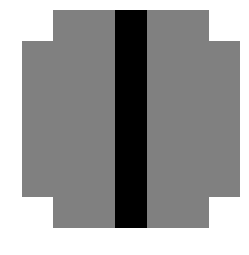

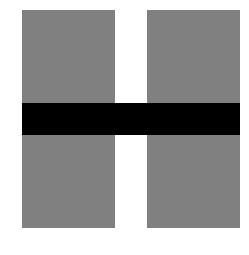

In [13]:
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

We define now the variable X that will be the input of the convolutional layer. It is also a tensor of four dimensions:

1. mini-batch size (how many instances (e.g. images) in the data)
2. image height 
3. image width
4. channels

In [14]:
# We reset the tensorflow computation graph
reset_graph()

# The variable is defined with only one channel
# and since usually we do not know in advance the batch size
# we do not specify it

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))

Now we define the convolutional layer

In [15]:
# This line forces tensorflow to use the CPU instead of the GPU
# I did this because had problems with my CPU. You can set 'GPU': 1
config = tf.ConfigProto(device_count = {'GPU': 0})

# A feature map is defined as a tensorflow constant using the fmap tensor we had
# previously defined
feature_maps = tf.constant(fmap)

# It follows the definition of the convolutional layer using the function tf.nn.conv2d()

# The second and third central values of the strides variable define the number
# of vertical and horizontal strides, respectively.
#  The "padding" variable can take two values: "SAME" (tensorflow add columns and rows
# to get an image of the same size" or "VALID": no column or row is padded and therefore
# convolved image has a smaller size

convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")



We run the session, get the output (convolved set of images)

In [16]:
# The session is created and the convolutional layer invoked
with  tf.Session(config=config) as sess:
    output = convolution.eval(feed_dict={X: images})


We show the two convolved images. Notice that when the vertical layer (the first image) is used the edges of the columns of the sculpture are clearly defined but the horizontal lines are blurred. For the second image horizontal lines are better defined. 

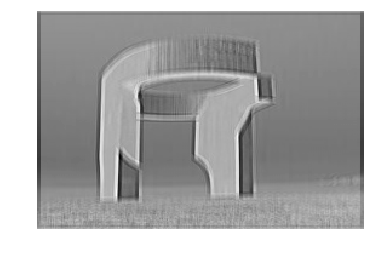

In [17]:
# Result of the application of the first kernel
plot_image(output[0, :, :, 0])
plt.show()

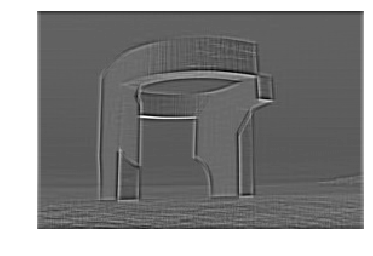

In [18]:
# Result of the application of the second kernel
plot_image(output[0, :, :, 1])
plt.show()

Finally, we illustrate the effect of an activation function (ReLU) on a convolved image. It further emphasises the most prominent features of the images. Remember the ReLU function is simply max(x,0)

In [19]:
# We define the relu function
apply_relu = tf.nn.relu(X)


We apply the activation function on the ouput of the second filter (output[0, :, :, 1])

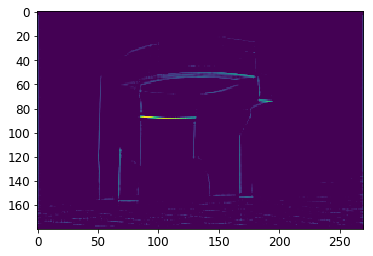

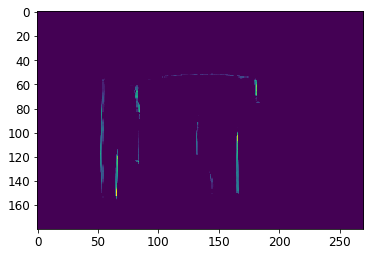

In [20]:
with  tf.Session(config=config) as sess:
    image_relu = sess.run(apply_relu, feed_dict={X:  output[0, :, :, 1].reshape((1,height, width,1))})
    image2_relu = sess.run(apply_relu, feed_dict={X:  output[0, :, :, 0].reshape((1,height, width,1))})
 
# The result of the application of the function is shown
plt.imshow(image_relu.reshape((height,width)))  # plot the output for the 1st image
plt.show()
plt.imshow(image2_relu.reshape((height,width)))  # plot the output for the 1st image
plt.show()


## Exercise 1

For the image loaded in the next cell, create a convolutional layer with three filters of size 5x5 and the following conditions.

1. The first filter is a vertical filter (value 1 in the matrix)
2. The second filter is a main diagonal filter (a line from (0,0) to (4,4)) (value -1 in the matrix)
3. The third filter is a filter with random values between zero and 1

Execute the layer and show the convolved images.


Suggestion: Reuse the previous code specifying the characteristics of the new set of filters as done with fmap before.

257 375 3


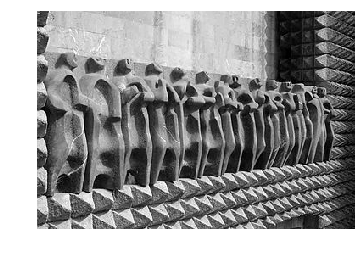

In [21]:

# We load the "Arantzazu.png" image 
image_C = mpimg.imread('cnn_images/Arantzazu.png')
#image_C = imageio.imread('cnn_images/CotorrasYPapagallos1-Curitiba.jpg')

height, width, channels = image_C.shape

# We transform it to grayscale
image_grayscale = image_C.mean(axis=2).astype(np.float32)


print(height, width, channels)

plot_image(image_grayscale)
a_images = image_grayscale.reshape(1, height, width, 1)
plt.show()

## Pooling layer

To define the pooling layer tensorflow provides functions tf.nn.max_pool() and tf.nn.ave_pool() and the parameters used are the same as for the convolutional layer (except that we do not need filters here). Therefore we do not discuss them here.

In [18]:

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))

# The max_pool layer is defined using a kernel of size 2x2 and SAME padding
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,1,1,1],padding="SAME")


# We apply the max_pool filter
with  tf.Session(config=config) as sess:
    output = sess.run(max_pool, feed_dict={X: a_images})
 


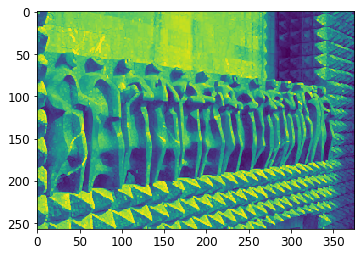

In [19]:
# We plot the effect of the maxpooling
mpool_image = output[0].reshape((height,width)).astype(np.uint8)
plt.imshow(mpool_image) 


## Using a trained Convolutional Network

We are going to start by getting in touch with CNNs implemented in tensorflow. 


- Access to the link https://github.com/tensorflow/models/tree/master/research/slim, go to the "Pre-trained Models" header and take some time to read the first paragraphs. You will understand why we are NOT learning a model for a realistic large dataset of photos in this Lab. 

- Also, see the list of models available. In principle, we will use the "inception_v3_2016_08_28.tar.gz" model in our Lab (do not download it yet), because it is highly accurate and still does not take as much memory and time as other models. You are free to use any other of the models for your DNN course project.

- Notice that tensorflow has realeased another independent library called TF-Slim, but we will use the "traditional" tensorflow library instead.


 We download inception_v3_2016_08_28.tar.gz file containing the Inception CNN implemented in tensorflow. 

In [20]:
# We keep the definition of these libraries in the cell so you can reuse this module
# to download other libraries

import sys
import tarfile
from six.moves import urllib


# We define the web address where the models are
# and the folder where it will be saved ( datasets/inception/)
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join("datasets", "inception")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

# Function to download the model
def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

We will also need the names of all the 1000 classes that the inception model is able to classify.

First you will need to obtain that file:

https://www.ehu.eus/zaindegi/index.php?action=download&item=class_names.txt&order=name&srt=yes

The password is mlnn

You can load them using the following cell.

In [21]:
# The file name will be saved in the directory where the model is 

import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    with open(os.path.join(INCEPTION_PATH, "class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return content.split("\n")
    


In the next cell, we show some of the classes represented in the model. During the lab, we will probably need the English dictionary to understand the meaning of some classes since they very specific. You can check the meaning here: https://dictionary.cambridge.org/

In [22]:
fetch_pretrained_inception_v3()
class_names = ["background"] + load_class_names()
load_class_names()
class_names[:1000:100]


['background',
 " 99: 'goose',",
 " 199: 'Scotch terrier, Scottish terrier, Scottie',",
 " 299: 'meerkat, mierkat',",
 " 399: 'abaya',",
 " 499: 'cleaver, meat cleaver, chopper',",
 " 599: 'honeycomb',",
 " 699: 'panpipe, pandean pipe, syrinx',",
 " 799: 'sliding door',",
 " 899: 'water jug',"]

The way we can upload the model is by creating a tensorflow model with the same characteristics of the inception_v3 model and then uploading the file and plugging it to the created model. We do this in the next cell.
It is important to notice that the inception_v3 model considers images of size 299x299. Therefore we will need to resize the images in order to be classified by the model. This is explained later.

In [23]:
# We read the inception module from tensorflow
from tensorflow.contrib.slim.nets import inception
# The slim library within tensorflow (different to TFSlim)
# contains different modules already implemented
import tensorflow.contrib.slim as slim

reset_graph()

# The inputs will be images of size 299x299 in three color channels
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")

with slim.arg_scope(inception.inception_v3_arg_scope()):
    # The model is defined, there are 1001 classes in the definition since one corresponds 
    # to "noise or other", and it is used only for training.
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
    
predictions = end_points["Predictions"]

# A saver is defined to load the model
saver = tf.train.Saver()

# The model is loaded
with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(INCEPTION_V3_CHECKPOINT_PATH, "inception_v3.ckpt"))

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


Since images need to be resized to 299x299 we will need a program that does this. The following program does this work.

In [24]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255



To test that the program that resizes the image works, modify the directory and the name of the image file in the cell below and read an image from your own directory. 

Notice that if the image is much larger than 299x299 the resizing program may select a different patch each time it is run. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Original image


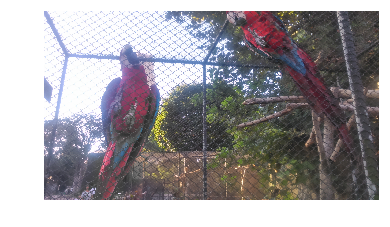

Resized image


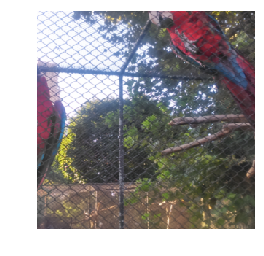

In [25]:
width = 299
height = 299
channels = 3


# Reads the desired image from the specified directory
#Im1 = mpimg.imread(os.path.join("cnn_images","CAM06487.jpg"))[:, :, :channels]
Im1 = mpimg.imread(os.path.join("cnn_images","CotorrasYPapagallos-Curitiba.jpg"))[:, :, :channels]

# Creates new image
new_image = prepare_image(Im1, target_width = width, target_height = height, max_zoom = 0.2)  

# Shows the image
print("Original image")
plt.imshow(Im1)
plt.axis("off")
plt.show()


# Shows the transformed image
print("Resized image")
plt.imshow(new_image)
plt.axis("off")
plt.show()



Now we use the inception network for predicting the class of the photograph. The output of the network will be a vector of 1000 probabilities. We assign the picture to the class of highest probability (even if this probability can be small). 

In [26]:
# We transform the image to a tensorflow representation 
# Remember that since the pictures have 3 channels the inputs
# to the network are actually 3 matrices

X_test = new_image.reshape(-1, height, width, channels)

# Predictions are evaluated
with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(INCEPTION_V3_CHECKPOINT_PATH, "inception_v3.ckpt"))
    predictions_val = predictions.eval(feed_dict={X: X_test})
    
# The most likely class is the one with the highest prob.
most_likely_class_indices = (-predictions_val[0]).argsort()

most_likely_names = []
# We create a list with class names corresponding to the predictions indices
for i in np.arange(5):
   most_likely_names.append(class_names[most_likely_class_indices[i]])

print("The most likely five classes for this picture are", most_likely_names)

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
The most likely five classes for this picture are [" 88: 'macaw',", " 489: 'chainlink fence',", " 90: 'lorikeet',", " 87: 'African grey, African gray, Psittacus erithacus',", " 96: 'toucan',"]


We can also plot the probabilities assigned to each class. 

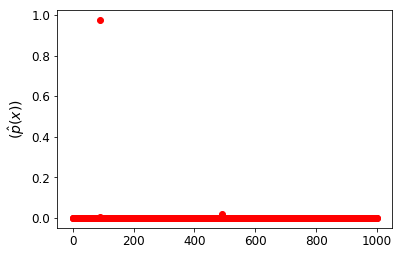

In [27]:
fsize = 14
fig = plt.figure()   
plt.plot(predictions_val[0,:],'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()     

When probabilities are small it is convenient to visualize the log-probabilities

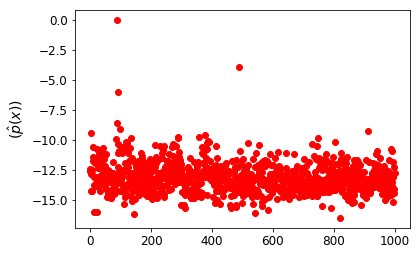

In [28]:
fsize = 14
fig = plt.figure()   
plt.plot(np.log(predictions_val[0,:]),'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()

## Exercise 2

- Modify the image filename  in the FOLLOWING CELL so you could evaluate the variability and accuracy in the output of the network for different pictures. You do not have to implement ANYTHING in this exercise, only change the filenames to assess the accuracy of the network when detecting the contents of your own pictures.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


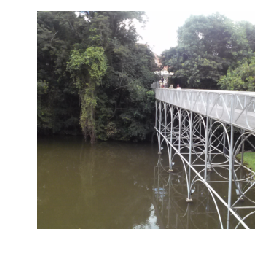

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
The most likely five classes for this picture are [" 821: 'steel arch bridge',", " 718: 'pier',", " 839: 'suspension bridge',", " 525: 'dam, dike, dyke',", " 979: 'valley, vale',"]


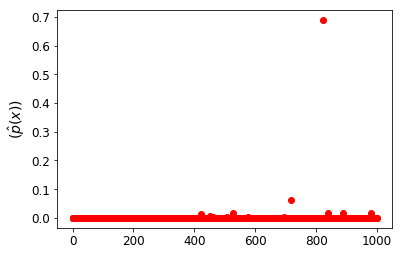

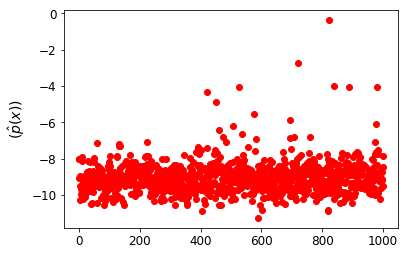

In [29]:
width = 299
height = 299
channels = 3


# Reads the desired image from the specified directory
Im1 = mpimg.imread(os.path.join("cnn_images","CAM06487.jpg"))[:, :, :channels]
#Im1 = mpimg.imread(os.path.join("cnn_images","CotorrasYPapagallos-Curitiba.jpg"))[:, :, :channels]

# Creates new image
new_image = prepare_image(Im1, target_width = width, target_height = height, max_zoom = 0.2)  

# Shows the image
plt.imshow(new_image)
plt.axis("off")
plt.show()


# We transform the image to a tensorflow representation 
X_test = new_image.reshape(-1, height, width, channels)

# Predictions are evaluated
with tf.Session(config=config) as sess:
    saver.restore(sess, os.path.join(INCEPTION_V3_CHECKPOINT_PATH, "inception_v3.ckpt"))
    predictions_val = predictions.eval(feed_dict={X: X_test})
    
# The most likely class is the one with highest prob.
most_likely_class_indices = (-predictions_val[0]).argsort()

most_likely_names = []
# We output the class names
for i in np.arange(5):
   most_likely_names.append(class_names[most_likely_class_indices[i]])

print("The most likely five classes for this picture are", most_likely_names)


fsize = 14
fig = plt.figure()   
plt.plot(predictions_val[0,:],'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()     

fsize = 14
fig = plt.figure()   
plt.plot(np.log(predictions_val[0,:]),'ro', lw=4)
plt.ylabel(r'$(\hat{p}(x))$', fontsize=fsize)
plt.show()



## Exercise 3

- Create a visual representation in two or three dimensions of all the pictures contained in your folder, where closer pictures in the representation are suppossed to have a similar content.


Suggestion 1: Create a list of all image filenames in you folder (number_pictures<=100)


Suggestion 2: Create a dataarray with the predictions of the network for each image file. It will have "number_pictures" rows and 1000 columns.

Suggestion 3: Apply dimensionality reduction on your dataarray to obtain only two dimensions for each picture (you can use sklearn function: http://scikit-learn.org/stable/modules/unsupervised_reduction.html

Suggestion 4: Plot the points (You can use the same plot function used in the previous cell or use a more sophisticated function from https://bokeh.pydata.org/en/latest/docs/gallery/color_scatter.html 


## Comment about Exercise 3



There is a follow up to Exercise 3 in Exercise 7, but first it is important to know how CNNs are implemented.

## Convolutional Network for MNIST

In the next cell we define a convolutional network to solve the MNIST classification problem. This network has the following characteristics:

### Architecture

- Layer 1.  Convolutional. It has 16 filters of size 3. Stride is 1. Padding=SAME. The activation function of this layer is ReLU.
- Layer 2.  Convolutional. It has 24 filters of size 3. Stride is 2. Padding=SAME. The activation function of this layer is ReLU.
- Layer 3.  Maxpooling. Filter size = 2.  Stride is 2. Padding=VALID. 
- Layer 4.  Full layer. 64 neurons.  The activation function of this layer is ReLU.
- Output layer. Output function  Softmax to compute probability of 10 output values. 

### Other characteristicss
- Loss function: softmax_cross_entropy
- Optimizer:     Adam optimizer


Read carefully the network implementation.




In [30]:
# We define the characteristics of the input image 
height = 28
width = 28
channels = 1
n_inputs = height * width

# We define the parameters of the layers according to 
# description previously presented

conv1_fmaps = 16       #32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 24     #64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10


# In this part the network architecture is defined
reset_graph()

with tf.name_scope("inputs"):
    # Variable X is passed as a vector
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    # It is reshaped to the tensor according to image size and channels
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    # Class of each MNIST image
    y = tf.placeholder(tf.int32, shape=[None], name="y")

# The first layer is defined. Notice that the tensorflow function used
# is tf.layers.conv2d(). Also, the parameters are those previously defined.


conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

# The second layer is defined. Notice that the input of this layer is the output
# of the previous layer. You can check that conv1 has size 28x28 and conv2 has
# size 14x14 (Try to find out why)

conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

# The maxpool layer is defined. Notice that the  tf.nn.max_pool() is used to define the layer.
# Also, maxpool is applied to each of the conv2_fmaps filters, and since the inputs have size
# 14x14, Stride=2 and Padding=Valid, after applying maxpool we have pool3_fmaps filters
# of size (7x7). That is the reason while the output is reshaped (flattened) to (pool3_fmaps * 7 * 7)

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

# This is the fully connected layer. From previous classes we already know function tf.layers.dense()
# used to define fully connected layers. 
# The number of input and output units is the same (pool3_fmaps * 7 * 7)
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

# This is the output layer where the network produces a classification for each class
# The classification is performed using the softmax function that we have studied in the previous lab
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

# The loss function and optimizers are defined as in previous labs.    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

# We define two functions to evaluate the quality of the network as a classifier
# The correct variable computes, for a batch of observations, how many were correctly classified.
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# We define a saver 
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Reading MNIST dataset 

In [31]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/")
mnist = input_data.read_data_sets('mnist_data') 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


We will train the network using batches of data of BATCH_SIZE size, to avoid problems with the GPU memory. Also, we will coumpute the accuracy in test set using batches. 

In [32]:
n_epochs = 3
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 10000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // BATCH_SIZE):
            X_batch, y_batch = mnist.train.next_batch(BATCH_SIZE)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(mnist.test.num_examples // BATCH_SIZE):
            X_batch, y_batch = mnist.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            #print(correct_pred)
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        #save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 0.99 Test accuracy: 0.9696
1 Train accuracy: 0.98 Test accuracy: 0.9799
2 Train accuracy: 0.98 Test accuracy: 0.9817


 Running the following two cells you can learn the the convolutional network, and test its accuracy for the fashion dataset.

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
fashion = input_data.read_data_sets('fashion_data') 

Extracting fashion_data/train-images-idx3-ubyte.gz
Extracting fashion_data/train-labels-idx1-ubyte.gz
Extracting fashion_data/t10k-images-idx3-ubyte.gz
Extracting fashion_data/t10k-labels-idx1-ubyte.gz


In [34]:
n_epochs = 10
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 10000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion.train.num_examples // BATCH_SIZE):
            X_batch, y_batch = fashion.train.next_batch(BATCH_SIZE)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(fashion.test.num_examples // BATCH_SIZE):
            X_batch, y_batch = fashion.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            #print(correct_pred)
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        #save_path = saver.save(sess, "./my_mnist_model")
    

0 Train accuracy: 0.99 Test accuracy: 0.9696
1 Train accuracy: 0.98 Test accuracy: 0.9799
2 Train accuracy: 0.98 Test accuracy: 0.9817
3 Train accuracy: 0.97 Test accuracy: 0.9836
4 Train accuracy: 0.98 Test accuracy: 0.9863
5 Train accuracy: 0.99 Test accuracy: 0.9846
6 Train accuracy: 0.99 Test accuracy: 0.9868
7 Train accuracy: 0.99 Test accuracy: 0.9874
8 Train accuracy: 1.0 Test accuracy: 0.9866
9 Train accuracy: 0.99 Test accuracy: 0.9876


## Exercise 4

Merging datasets MNIST and Fashion, we will create a joint dataset of 20 classes, 20000 training instances, and 20000 test instances. Create and execute a convolutional neural network that classifies any image in one of the 20 classes. To test your network in the joint set of data, execute the following cell, but first you need to create the new network.

The CNN should have the following parameters.

### Architecture

- Layer 1.  Convolutional. It has 20 filters of size 5. Stride is 1. Padding=SAME. The activation function of this layer is ReLU.
- Layer 2.  Convolutional. It has 40 filters of size 2. Stride is 2. Padding=SAME. The activation function of this layer is ReLU.
- Layer 3.  Average pooling. Filter size = 2.  Stride is 2. Padding=VALID. 
- Layer 4.  Full layer. 64 neurons.  The activation function of this layer is ReLU.
- Output layer. Output function  Softmax to compute probability of 20 output values. 

### Other characteristicss
- Loss function: softmax_cross_entropy
- Optimizer:     Adam optimizer




In [35]:
#  You can set the definition of your network in this cell and run it in the following cell











In [36]:
n_epochs = 10
IMAGE_SIZE = 28
NUM_CHANNELS = 1
BATCH_SIZE = 100
test_size = 20000

with  tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion.train.num_examples // BATCH_SIZE):
          
            X_batch_mnist, y_batch_mnist = mnist.train.next_batch(BATCH_SIZE)
            X_batch_fashion, y_batch_fashion = fashion.train.next_batch(BATCH_SIZE)
            # We concatenate the batch from the two datasets
            X_batch = np.vstack((X_batch_mnist,X_batch_fashion))
            # The labels of the fashion dataset will be now from 10 to 19
            y_batch = np.hstack((y_batch_mnist,10+y_batch_fashion))
                
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})

        
        correct_pred = 0
        for iteration in range(fashion.test.num_examples // BATCH_SIZE):     
            # For computing the accuracy in test, we add the number of correct
            # predictions for the two sets
            
            X_batch, y_batch = mnist.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: y_batch}))
            X_batch, y_batch = fashion.test.next_batch(BATCH_SIZE)
            correct_pred += np.sum(correct.eval(feed_dict={X: X_batch, y: 10+y_batch}))
            
        acc_test = (correct_pred / float(test_size))
        #acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

InvalidArgumentError: Received a label value of 19 which is outside the valid range of [0, 10).  Label values: 7 2 0 4 8 9 7 8 1 0 4 8 5 6 7 9 9 7 1 3 4 0 5 4 6 1 6 1 5 3 3 6 8 9 7 4 7 5 0 0 5 9 7 0 7 8 9 7 5 4 6 1 7 4 6 8 7 3 6 8 2 0 4 8 4 9 2 0 7 4 3 7 4 6 0 9 1 7 5 9 8 0 4 5 8 5 8 3 1 9 5 8 4 0 8 0 1 4 0 2 10 16 17 15 11 17 19 19 16 15 13 15 18 17 13 13 14 16 17 17 19 14 16 16 15 18 13 11 17 12 18 17 13 18 13 18 10 10 19 16 12 12 19 19 16 18 19 16 12 16 14 10 18 18 13 17 10 16 10 13 11 10 10 17 12 16 16 10 13 16 15 19 14 16 15 18 14 10 11 17 15 12 10 17 16 16 10 12 15 17 15 11 15 17 19 15 13 13 18 10
	 [[Node: train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](output/output/BiasAdd, _arg_inputs/y_0_1)]]

Caused by op 'train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-8245726986cf>", line 76, in <module>
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_ops.py", line 1964, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 4804, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of 19 which is outside the valid range of [0, 10).  Label values: 7 2 0 4 8 9 7 8 1 0 4 8 5 6 7 9 9 7 1 3 4 0 5 4 6 1 6 1 5 3 3 6 8 9 7 4 7 5 0 0 5 9 7 0 7 8 9 7 5 4 6 1 7 4 6 8 7 3 6 8 2 0 4 8 4 9 2 0 7 4 3 7 4 6 0 9 1 7 5 9 8 0 4 5 8 5 8 3 1 9 5 8 4 0 8 0 1 4 0 2 10 16 17 15 11 17 19 19 16 15 13 15 18 17 13 13 14 16 17 17 19 14 16 16 15 18 13 11 17 12 18 17 13 18 13 18 10 10 19 16 12 12 19 19 16 18 19 16 12 16 14 10 18 18 13 17 10 16 10 13 11 10 10 17 12 16 16 10 13 16 15 19 14 16 15 18 14 10 11 17 15 12 10 17 16 16 10 12 15 17 15 11 15 17 19 15 13 13 18 10
	 [[Node: train/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](output/output/BiasAdd, _arg_inputs/y_0_1)]]


## Designing a simple CNN in keras 

The following auxiliary function is used to read the mnist and fashion datasets

In [37]:
def Read_And_Normalize_Image_Dataset(db_name='mnist', max_train_samples = 10000,max_test_samples = 10000):

    if db_name=='mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()               
    elif db_name=='fashion':
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()        
        
    #print(x_train.shape,y_train.shape)
    #print(x_test.shape,y_test.shape)

        
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)
    #x_train = x_train.reshape((len(x_train), 28*28))
    #x_test = x_test.reshape((len(x_test), 28*28))

    return (x_train, y_train), (x_test, y_test) 


We read the mnist dataset and transform the classes to categorical (one_hot) representation

In [38]:
from keras.datasets import mnist, fashion_mnist, boston_housing

K.set_session(tf.Session(config=config))  # To avoid problems with the GPU. Delete to work with it.

(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) \
                                = Read_And_Normalize_Image_Dataset(db_name='mnist', \
                                max_train_samples = 10000, max_test_samples = 10000)


print("Dimension of the samples in the training set: ", x_mnist_train.shape)
print("Dimension of samples in the test set: ", x_mnist_test.shape)

number_mnist_classes = 10
y_mnist_train_one_hot  = to_categorical(y_mnist_train)
y_mnist_test_one_hot  = to_categorical(y_mnist_test)

print("Dimension of the labels training set (one_hot): ", y_mnist_train_one_hot.shape)
print("Dimension of the labels test set (one_hot): ", y_mnist_test_one_hot.shape)

Dimension of the samples in the training set:  (60000, 28, 28, 1)
Dimension of samples in the test set:  (10000, 28, 28, 1)
Dimension of the labels training set (one_hot):  (60000, 10)
Dimension of the labels test set (one_hot):  (10000, 10)


The next model is a convolutional network used to classify digits in the mnist dataset

In [39]:
n_inputs = 28
input_shape = (n_inputs, n_inputs,1)

# The model is declared
mnist_conv_model = Sequential()
mnist_conv_model.add(Conv2D(30, kernel_size=(5, 5),activation='relu',
                            input_shape=input_shape))

mnist_conv_model.add(MaxPooling2D(pool_size=(2, 2)))

mnist_conv_model.add(Conv2D(15, kernel_size=(3, 3),activation='relu'))
mnist_conv_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_conv_model.add(Dropout(0.25))
mnist_conv_model.add(Flatten())
mnist_conv_model.add(Dense(128, activation='relu'))
mnist_conv_model.add(Dense(50, activation='relu'))
mnist_conv_model.add(Dense(number_mnist_classes, activation='softmax'))


mnist_conv_model.compile(loss='categorical_crossentropy', optimizer='adam',
                         metrics=['accuracy'])


# A summary of the model is printed
print(mnist_conv_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               48128     
__________

We use the following auxiliary function plot_history() to inspect the training of the network

In [40]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [41]:
print(x_mnist_test.shape, y_mnist_test_one_hot.shape)

(10000, 28, 28, 1) (10000, 10)


Execute the following cell to train the network

In [42]:
batch_size = 40
epochs = 8
history = mnist_conv_model.fit(x_mnist_train, y_mnist_train_one_hot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_mnist_test, y_mnist_test_one_hot))

score = mnist_conv_model.evaluate(x_mnist_test, y_mnist_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 20s 336us/step - loss: 0.2082 - acc: 0.9324 - val_loss: 0.0533 - val_acc: 0.9813
Epoch 2/8
60000/60000 [==============================] - 19s 318us/step - loss: 0.0757 - acc: 0.9762 - val_loss: 0.0447 - val_acc: 0.9868
Epoch 3/8
60000/60000 [==============================] - 19s 323us/step - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0349 - val_acc: 0.9883
Epoch 4/8
60000/60000 [==============================] - 19s 323us/step - loss: 0.0466 - acc: 0.9854 - val_loss: 0.0319 - val_acc: 0.9903
Epoch 5/8
60000/60000 [==============================] - 20s 327us/step - loss: 0.0434 - acc: 0.9863 - val_loss: 0.0357 - val_acc: 0.9889
Epoch 6/8
60000/60000 [==============================] - 20s 325us/step - loss: 0.0374 - acc: 0.9887 - val_loss: 0.0313 - val_acc: 0.9899
Epoch 7/8
60000/60000 [==============================] - 20s 330us/step - loss: 0.0310 - acc: 0.9895 - val_loss: 0.0307 - 

Plot the history

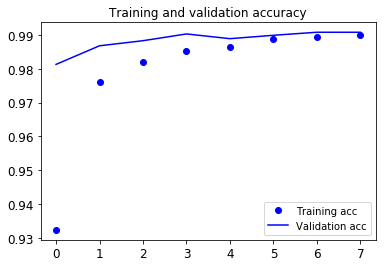

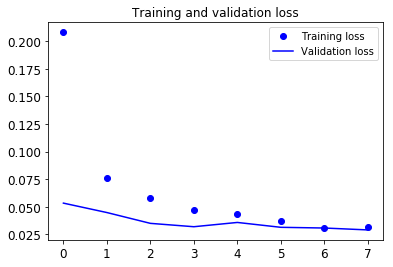

In [43]:
plot_history(history)

## Exercise 5 

 1) Design and train a network for the fashion dataset.
 
 2) Visualize the history of the training process 
 
 3) Compute the confusion matrix for the predictions on the testset. 
 
 
Hints: 
- Images in the fashion dataset has the same dimension that in the mnist dataset
- Function Read_And_Normalize_Image_Dataset() [see details above]  can be used to download and preprocess this data


## Cats and dogs  dataset 

First of all, you will need to download the dataset. We have already made a reduced version of the DB, because of the larme number of examples. It can be found in the following link. The password is mlnn.

https://www.ehu.eus/zaindegi/index.php?action=download&item=cats_and_dogs_small.zip&order=name&srt=yes


Execute the following cells to read information about the dataset. 

In [44]:
import os, shutil

base_dir = 'cats_and_dogs_small'

# Directories for our training,  validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')



In the following cell we define a function that creates a model to classify the images in the dataset 

In [45]:
def build_network():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    model.summary()
    return model


A function that learns a model taking images directly from the directory where the train data is defined in the following cell

In [46]:
def train_network_with_no_augmentation():
    model = build_network()

    # All images will be rescaled by 1./255
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to 150x150
            target_size=(150, 150),
            batch_size=20,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break


    history = model.fit_generator(
          train_generator,
          steps_per_epoch=15,  # steps_per_epoch=100,
          epochs=20,          # epochs=30
          validation_data=validation_generator,
          validation_steps=10)  # validation_steps=50)

    model.save('cats_and_dogs_small_1.h5')
    return history




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)       147584    
__________

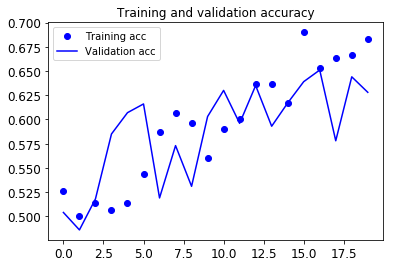

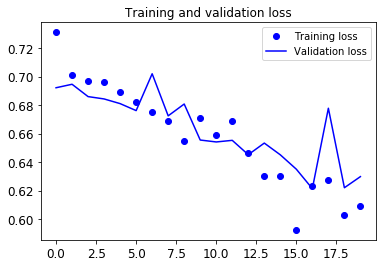

In [48]:
cat_dogs_history = train_network_with_no_augmentation()
plot_history(cat_dogs_history)

In the next example we will learn a network but using data aumentation. Execute the following two cells that illustrate how data augmentation is implemented in keras. 

In [49]:
def demo_augmentation():
    datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    train_cats_dir = os.path.join(train_dir, 'cats')
    fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

    # We pick one image to "augment"
    img_path = fnames[3]

    # Read the image and resize it
    img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))

    # Convert it to a Numpy array with shape (150, 150, 3)
    x = keras.preprocessing.image.img_to_array(img)

    # Reshape it to (1, 150, 150, 3)
    x = x.reshape((1,) + x.shape)

    # The .flow() command below generates batches of randomly transformed images.
    # It will loop indefinitely, so we need to `break` the loop at some point!
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        plt.figure(i)
        imgplot = plt.imshow(keras.preprocessing.image.array_to_img(batch[0]))
        i += 1
        
        if i % 4 == 0:
            break

    plt.show()

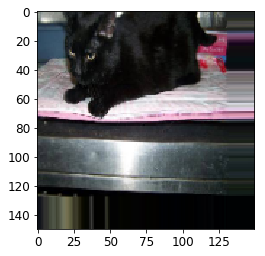

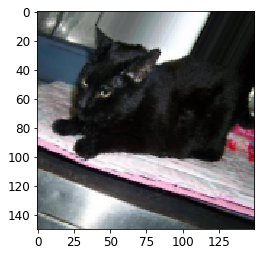

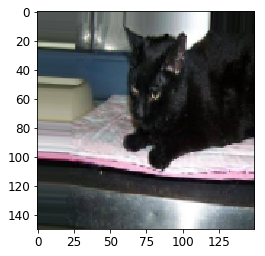

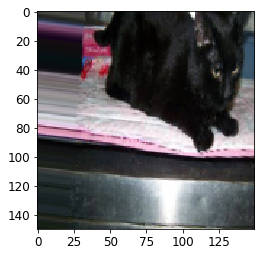

In [50]:
demo_augmentation()

In the next two cells a new model that includes data augmentation and dropout is included. You can execute the model but only after reducing the number of epochs and steps because the time it takes to train. 

In [51]:
def build_network_with_dropout():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model


In [54]:
def train_network_with_augmentation():
    model = build_network_with_dropout()

    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)


    # Note that the validation data should not be augmented!
    test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to 150x150
            target_size=(150, 150),
            batch_size=32,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')

    model = build_network_with_dropout()

    history = model.fit_generator(
          train_generator,
          steps_per_epoch=100,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=50)

    model.save('cats_and_dogs_small_2.h5')
    return history

In [55]:
train_network_with_augmentation()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 84s 844ms/step - loss: 0.6910 - acc: 0.5263 - val_loss: 0.6811 - val_acc: 0.5190
Epoch 2/10
100/100 [==============================] - 86s 858ms/step - loss: 0.6745 - acc: 0.5672 - val_loss: 0.6562 - val_acc: 0.5990
Epoch 3/10
100/100 [==============================] - 82s 820ms/step - loss: 0.6675 - acc: 0.5944 - val_loss: 0.6600 - val_acc: 0.5960
Epoch 4/10
100/100 [==============================] - 82s 815ms/step - loss: 0.6448 - acc: 0.6084 - val_loss: 0.6309 - val_acc: 0.6410
Epoch 5/10
100/100 [==============================] - 84s 842ms/step - loss: 0.6225 - acc: 0.6475 - val_loss: 0.6651 - val_acc: 0.6140
Epoch 6/10
100/100 [==============================] - 83s 832ms/step - loss: 0.6005 - acc: 0.6772 - val_loss: 0.5951 - val_acc: 0.6820
Epoch 7/10
100/100 [==============================] - 81s 813ms/step - loss: 0.6028 - acc: 0.6638 - val_lo

It is also possible to use a network to evaluate the activations of the filters in each layer for a given image.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

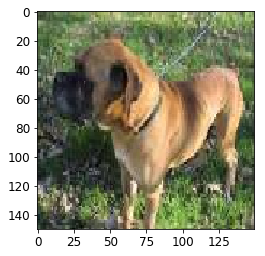

(1, 75, 75, 128)
block1_conv1


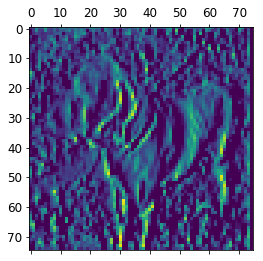

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


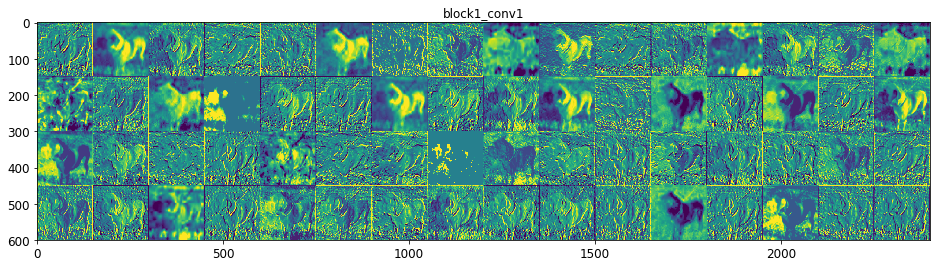

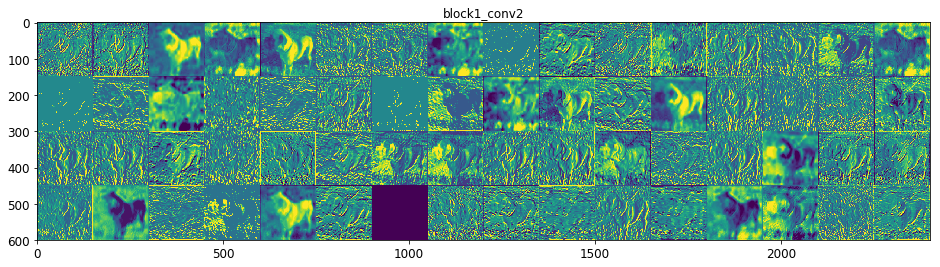

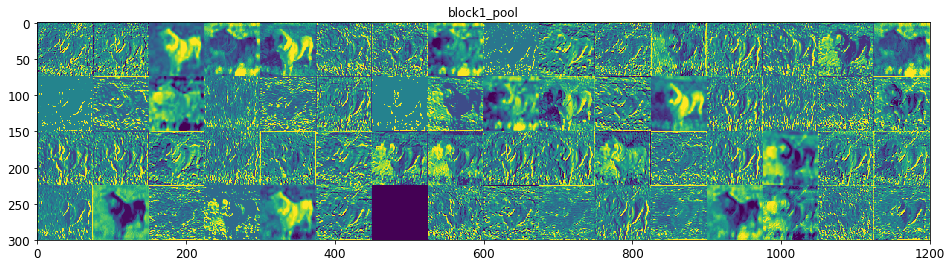

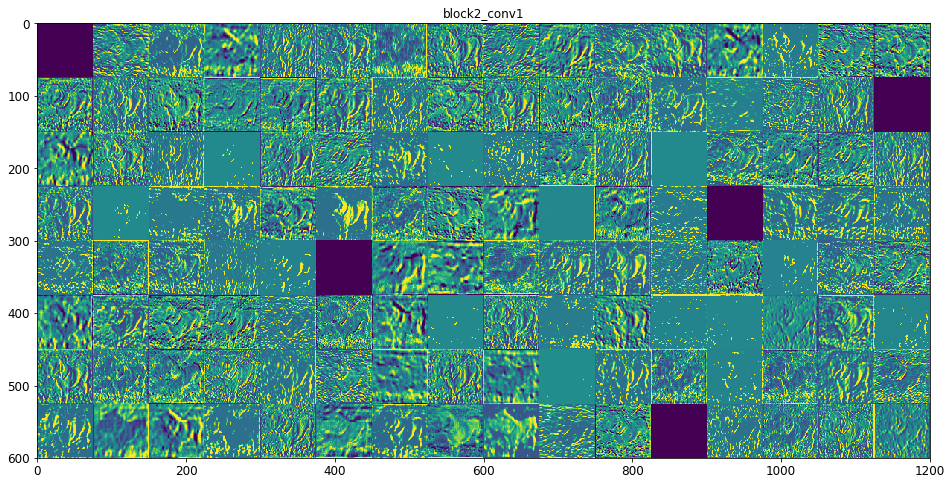

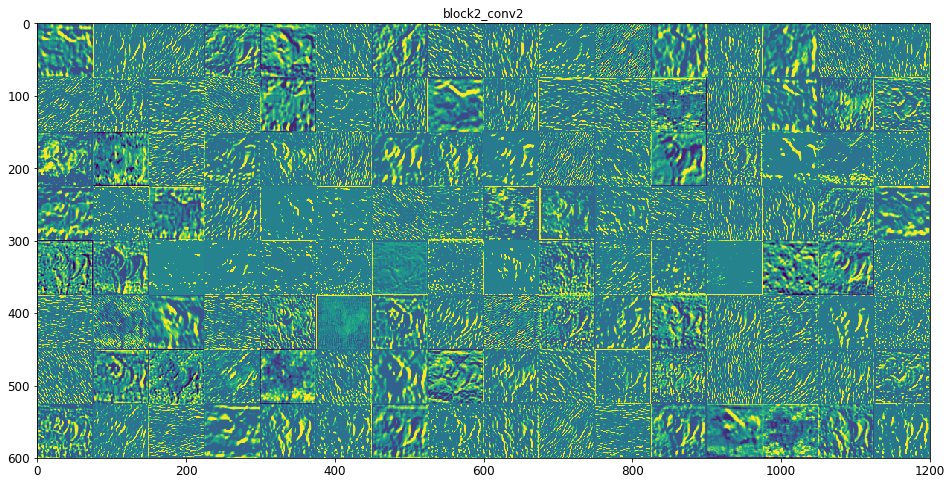

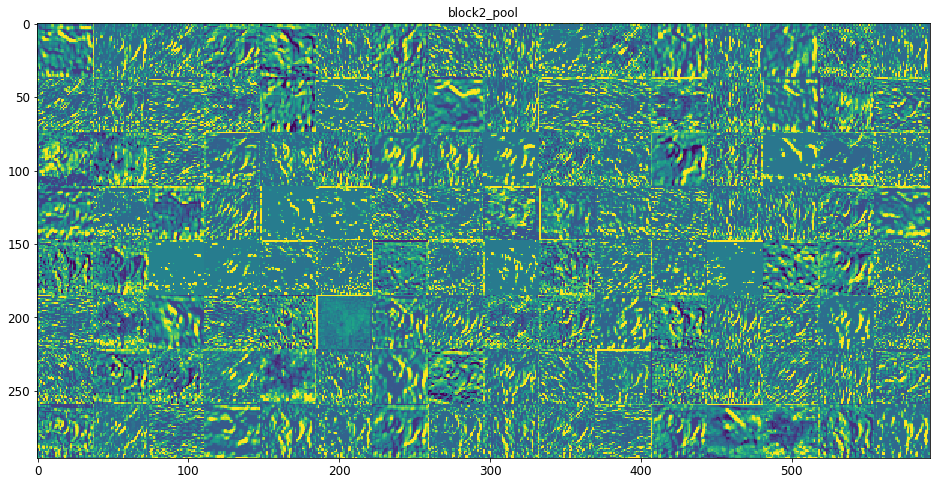

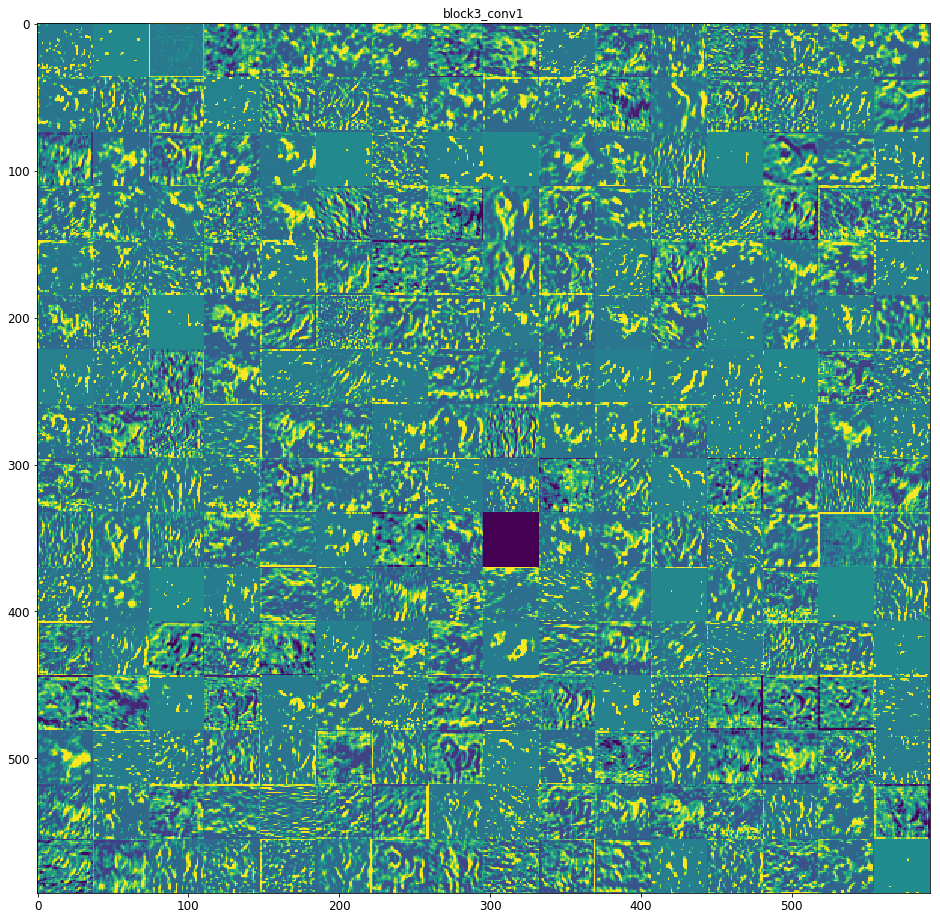

In [56]:
def visualizing_intermediate_activations():
    model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model.summary()
    #img_path = os.path.join(base_dir, 'cat.1700.jpg')
    #img_path = os.path.join(base_dir, 'cat.3179.jpg')
    img_path = os.path.join(train_dir, 'dogs/dog.11.jpg')

    img = keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_tensor = keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.


    plt.imshow(img_tensor[0])
    plt.show()


    # Extracts the outputs of the top 8 layers:
    layer_outputs = [layer.output for layer in model.layers[1:8]]
    # Creates a model that will return these outputs, given the model input:
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # This will return a list of 5 Numpy arrays:
    # one array per layer activation
    activations = activation_model.predict(img_tensor)

    first_layer_activation = activations[3]
    print(first_layer_activation.shape)
    print(model.layers[1:8][0].name)

    plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
    plt.show()

    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[1:8]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                :, :,
                                col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
    
visualizing_intermediate_activations()


## Using a trained Convolutional Network in keras to predict a class

We use one of the most powerful networks to predict which is the content of the image. You can download one image from the web and use the function to evaluate its accuracy

In [57]:
# We read relevant libraries from keras

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import PIL

In [58]:
def  Predict_Image_Content(img,number_top_predictions):
    model = ResNet50(weights='imagenet')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)


    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    return decode_predictions(preds, top=number_top_predictions)[0]



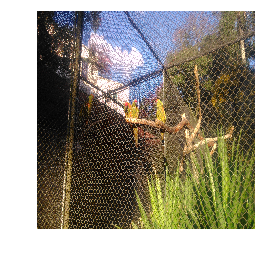

Predicted: [('n03000134', 'chainlink_fence', 0.5267826), ('n04589890', 'window_screen', 0.38547623), ('n04275548', 'spider_web', 0.037093893), ('n03388043', 'fountain', 0.026629942), ('n02727426', 'apiary', 0.0022516893), ('n03530642', 'honeycomb', 0.0013558945), ('n04366367', 'suspension_bridge', 0.0012955988), ('n02497673', 'Madagascar_cat', 0.001016964), ('n02494079', 'squirrel_monkey', 0.0009849808), ('n02483708', 'siamang', 0.0009336282)]


In [59]:
#img_path = 'cnn_images/IlhaDoMel.png'
img_path = 'cnn_images/CotorrasYPapagallos1-Curitiba.jpg'
#img_path = 'cat.1700.jpg'
img = image.load_img(img_path, target_size=(224,224))
plot_image(img)
plt.show()

number_top_predictions =10

predictions = Predict_Image_Content(img,number_top_predictions)

print('Predicted:',predictions)


### Image features are extracted using a VGG16 network

In [60]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


model = VGG16(weights='imagenet', include_top=False)

img_path = 'cnn_images/IlhaDoMel.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

print("The dimensions of the features are:", features.shape)
    

The dimensions of the features are: (1, 7, 7, 512)


Some of the kernels are visualized

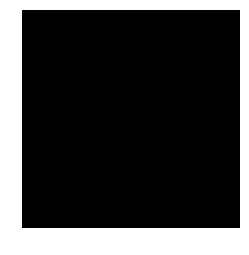

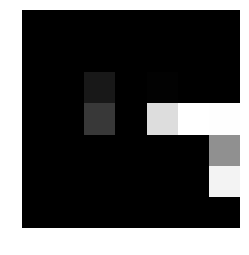

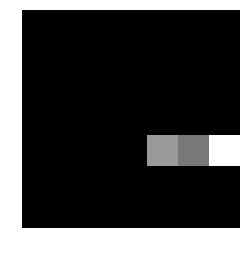

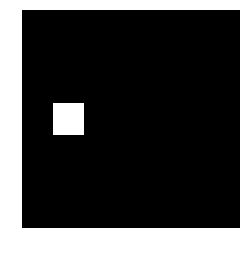

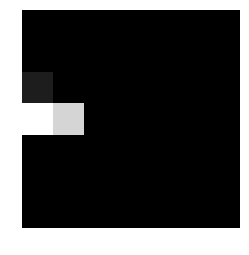

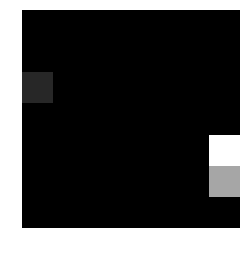

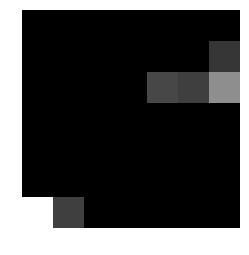

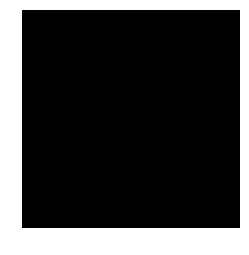

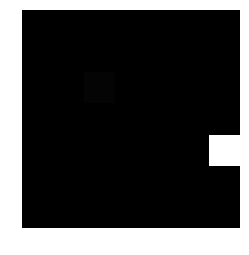

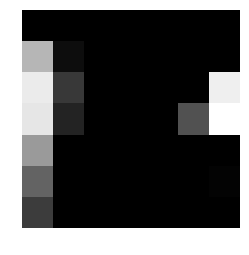

In [61]:
for i in range(104,114):
    channel_image  = features[0,:,:,i]
    plot_image(channel_image)
    a_images = channel_image.reshape(1, 7, 7, 1)
    plt.show()

### Extracting the features from a user-defined layer ('block4_poo') of the VGG19 network

In [62]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = 'cnn_images/CotorrasYPapagallos1-Curitiba.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = model.predict(x)

print("The dimensions of the features are:", block4_pool_features.shape)


The dimensions of the features are: (1, 14, 14, 512)


Some of the kernels are visualized

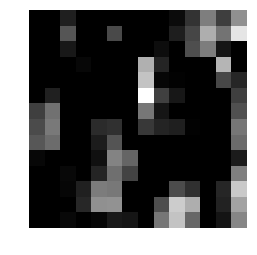

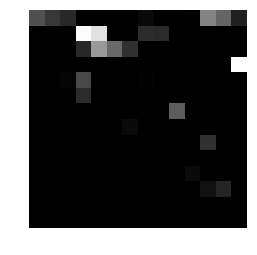

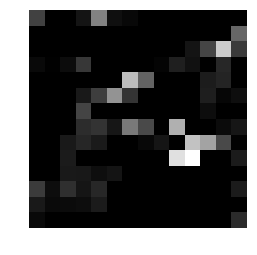

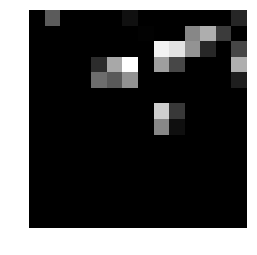

In [63]:
for i in range(4):
    kernel = block4_pool_features[0,:,:,i]
    plot_image(kernel)
    a_images = kernel.reshape(1, 14,14, 1)
    plt.show()


## Advanced use of CNNs with keras. 


### Pre-defined networks can be adapted to new classification problems but selectively training only some of the layers.  In the example below, the inception network is modified.


In [64]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import to_categorical

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



In [65]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_28 

In [66]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)


train_generator = train_datagen.flow_from_directory(
            # This is the target directory
            train_dir,
            # All images will be resized to 150x150
            target_size=(150, 150),
            batch_size=32,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='binary')

# Note that the validation data should not be augmented!
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')

# Transform 
validation_generator.classes = to_categorical(validation_generator.classes)
train_generator.classes = to_categorical(train_generator.classes)

history1 = model.fit_generator(
          train_generator,
          steps_per_epoch=10,
          verbose=1,
          epochs=5,
          validation_data=validation_generator,
          validation_steps=10)


# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history2 = model.fit_generator(
          train_generator,
          verbose=1,
          steps_per_epoch=10,
          epochs=5,
          validation_data=validation_generator,
          validation_steps=10)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
10/10 [==============================] - 57s 6s/step - loss: 3.4803 - val_loss: 2.9581
Epoch 2/5
10/10 [==============================] - 56s 6s/step - loss: 0.9848 - val_loss: 0.4759
Epoch 3/5
10/10 [==============================] - 54s 5s/step - loss: 0.7819 - val_loss: 0.6110
Epoch 4/5
10/10 [==============================] - 58s 6s/step - loss: 0.6308 - val_loss: 0.4221
Epoch 5/5
10/10 [==============================] - 56s 6s/step - loss: 0.7570 - val_loss: 1.0194
0 input_5
1 conv2d_27
2 batch_normalization_1
3 activation_50
4 conv2d_28
5 batch_normalization_2
6 activation_51
7 conv2d_29
8 batch_normalization_3
9 activation_52
10 max_pooling2d_28
11 conv2d_30
12 batch_normalization_4
13 activation_53
14 conv2d_31
15 batch_normalization_5
16 activation_54
17 max_pooling2d_29
18 conv2d_35
19 batch_normalization_9
20 activation_58
21 conv2d_33
22 conv2d_36
23 batch_normalization_7
24 batch_

## Exercise 6

Now that we understand how to partially train Keras models, we can put our knowledge into practice. For that, we are going to select a different model, NASNet for example (https://keras.io/applications/#nasnet, but it could be any other). We will, similarly to what we have done, append an arbitrary number of dense layers, and test that model with the MNIST dataset. Note that we will not be using a directory-based DB, therefore, we will need to remember how a Keras model was trained in the previous exercises in this notebook.

## Exercise 7

The clustering organization in Exercise 3 might not be very accurate since two pictures in the same category may be represented by different variables. It makes more sense to measure how close are concepts predicted by the CNN. We can measure the similarity between classes using word similarity. Now, you can use the implementations shown in the following cells to compute of matrix of similarity between images, and cluster the images using this similarity.
For example, images whose words are closer, will be closer in the representation. 


If you get an error running the following cell, uncomment the last two lines and comment the first.
Then run the cell, in the "corpora" column select "wordnet"


In [67]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [68]:
from nltk.corpus import wordnet as wn

def word_similarity(w1,w2):
    similarity = 0
    w1sets = wn.synsets(w1)
    w2sets = wn.synsets(w2)
    #print(w1sets,w2sets)
    
    pairs_meanings = []
    for i in w1sets:
        for j in w2sets:
            #pairs_meanings.append(i.path_similarity(j))
            pairs_meanings.append(i.wup_similarity(j))

    similarity = np.nanmax(np.array(pairs_meanings, dtype=np.float64))
    return similarity

word1 = 'rose'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between rose and horse: ', ws)

word1 = 'rose'
word2 = 'sunflower'
ws = word_similarity(word1,word2)
print('The similarity between rose and sunflower: ', ws)

word1 = 'dog'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between dog and horse: ', ws)

word1 = 'zebra'
word2 = 'horse'
ws = word_similarity(word1,word2)
print('The similarity between zebra and horse: ', ws)

The similarity between rose and horse:  0.46153846153846156
The similarity between rose and sunflower:  0.6956521739130435
The similarity between dog and horse:  0.7586206896551724
The similarity between zebra and horse:  0.9333333333333333
